# Final Project
Travis Zhang and Lauren Greenhill

## Problem Statement
Many prominent CEOs and leaders hold public social media accounts to convey their, and their activity on social media can oftentimes affect the reputation of him/her and the company he/she represents. Elon Musk, a leader known for his active presence on social media, particularly Twitter, has frequently written controversial Tweets that have affected Tesla’s stock.

## Hypothesis
We hypothesize that there is correlation between Elon’s Tweets and Tesla stock.

## Data Processing
We could not find a dataset that fit exactly what we were looking for, so we decided to create our own using Tweepy, a Twitter API and yfinance, a python module for the deprecated Yahoo Finance API. One shortcoming of our project is the lack of data we were able to gather. The Twitter API limits users to apprximately 3500 tweets. The Yahoo Finance API only provides stock data by day.

### Twitter Data
From Twitter we were able to gather data on all of Elon Musk’s tweets from January 25, 2020 to November 22, 2020. For each tweet we logged the creation data, content of the tweet, the number of retweets, and the number of favorites. 
- Twitter data scraping code: https://github.com/ljgreenhill/ElonAnalysis/blob/main/code/twitterAPI.py
- CSV of data: https://github.com/ljgreenhill/ElonAnalysis/blob/main/data/tweets.csv

We then ran these tweets through a pretrained sentiment analyzer. 
- Sentiment analysis code: https://github.com/ljgreenhill/ElonAnalysis/blob/main/code/Sentiment%20Analysis.ipynb
- CSV of data: https://github.com/ljgreenhill/ElonAnalysis/blob/main/data/sentiment.csv

### Stock Data
The stock data gathered from Yahoo Finance ranged from June 29, 2010 to November 20, 2020, and the data included Open prices, Close prices, Low prices, High prices, Volume, Dividends, and Stock Splits. For our project, because we were limited by the
Twitter data, we had to restrict our stock data to the same dates. We calculated the change in prices per day when the market was open by subtracting the stock price when the market closed with the stock price when the market opened.
- Code to pull stock data and combine with twitter data: https://github.com/ljgreenhill/ElonAnalysis/blob/main/code/Dataset%20Retrieval.ipynb
- Combined CSV: https://github.com/ljgreenhill/ElonAnalysis/blob/main/data/elon.csv

## Data Visualization
Let us first visualize the data.

### Correlation Matrix
The first and most obvious type of data visualization that is necessary for our project is plotting the correlation matrix. This will tell us the relationship between the sentiment analysis and the stock trends.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/sentiment.csv', index_col=0)
data = data.drop(columns=['Text'])
data.head()

,Change In Price,Favorites,Retweets,Negative,Neutral,Positive,Compound
2020-01-27,3.205994,6544.600000,814.000000,0.030,0.853,0.117,0.7959
2020-01-28,-0.318001,79576.500000,6452.666667,0.000,0.813,0.187,0.8718
2020-01-29,1.059998,35996.769231,4025.000000,0.028,0.715,0.257,0.9775
2020-01-30,1.678001,53946.166667,4608.000000,0.129,0.842,0.028,-0.5707
2020-01-31,2.113998,53814.944444,5062.500000,0.043,0.716,0.241,0.9726


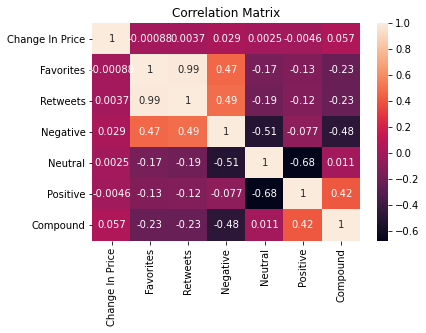

In [2]:
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

Although the correlation matrix indicates that the change in price's correlation with the sentiment analysis was low, we believe that low correlation could be due to a few reasons: 
- Not enough data to accurately identify the relationship: We only had around 200 data points to use and manipulate 
- Our sentiment analysis could have made inaccurate predictions: Because Elon Musk is notorious for tweeting a lot within a day, we decided to consolidate all the tweets for each day and performing sentiment analysis on the collections of tweets per day rather than on each individual tweet. Although this was significantly more feasible (given our available data) and more efficient, the sentiment analysis could be inaccurate (some tweets could be extremely negative while other tweets could be extremely positive resulting in an overall neutral stance.)

In [3]:
# Uses regex to remove URLs from a sample string
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

# Uses regex to remove @ tweet mentions from a sample string
def remove_tweet_mentions(sample):
    return re.sub(r"@\S+", "", sample)

# Uses regex to remove all emojis
def remove_emojis(sample):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',sample)

def fix_spacing(sample):
    return re.sub('\s+',' ',sample)

def preprocess_data(sample):
    sample = remove_URL(sample)
    sample = remove_emojis(sample)
    sample = remove_tweet_mentions(sample)
    sample = fix_spacing(sample)
    
    return sample

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import nltk

nltk.download('vader_lexicon')
data_viz = pd.read_csv('data/elon.csv', index_col=0)
data_viz["Text"] = data_viz.apply(lambda row : preprocess_data(row['Text']), axis=1).dropna()
sid = SentimentIntensityAnalyzer()

summary = {"positive":0,"neutral":0,"negative":0}
for x in data_viz["Text"]: 
    ss = sid.polarity_scores(x)
    if ss["compound"] >= 0.05: 
        summary["positive"] +=1
    elif ss["compound"] <= -0.05:
        summary["negative"] +=1
    else:
        summary["neutral"] +=1
print(summary)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/traviszhang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'positive': 177, 'neutral': 7, 'negative': 18}


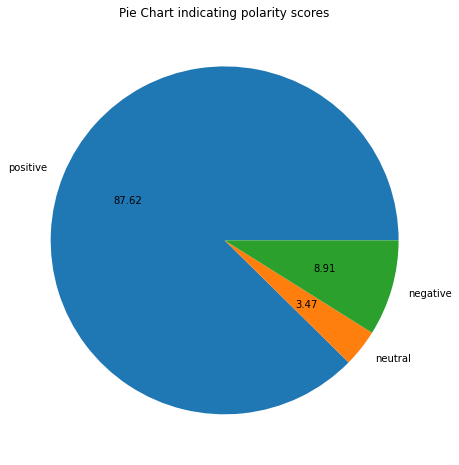

In [5]:
plt.figure(figsize=(8,8))
plt.title('Pie Chart indicating polarity scores')
plt.pie([float(v)/sum(summary.values()) for v in summary.values()], labels=[k for k in summary.keys()],
           autopct='%.2f')
plt.show()

The pie chart indicates that the sentiment analysis considered most of Elon's tweets as positive. However, we believe that it fails to capture the subtlety and nuances of the English language. For instance, the sentiment analysis seems to fail to consider sarcastic/controversial comments, which Elon tweets about quite a bit. An instance where the analyzer treated a tweet as positive (Compound > 0.05) is when Elon tweeted that "Tesla stock price is too high imo" which should be a negative tweet that lead to a decrease in TSLA stock.

### The analysis we got for the day which contained the tweet mentioned above: 

##### Tweets on May 1, 2020:

We’re going to try landing Starship on the moon with enough propellant to return to Earth, How much for some anime Bitcoin? , Reality is its own parrot parody, There will be no Mars if we let them take our freedom away, bring it on, As always, I am optimistic about Tesla long-term, , Baby due on Monday, Don’t need the cash. Devoting myself to Mars and Earth. Possession just weigh you down.,My gf is mad at me,Just one stipulation on sale: I own Gene Wilder’s old house. It cannot be torn down or lose any its soul.,Rage, rage against the dying of the light of consciousness, Exactly. How cheaply freedom is sold.,O'er the land of the free and the home of the brave?,Oh, say does that star-spangled banner yet wave,Gave proof through the night that our flag was still there,And the rocket's red glare, the bombs bursting in air,Now give people back their FREEDOM,Tesla stock price is too high imo,I am selling almost all physical possessions. Will own no house., Incentives matter, Starship is making good progress,RT Why our Launch of the &amp; Demo-2 Mission to the is Essential: What is real any more, You got it!, Exactly, Well said

##### Polarity Scores: 
<br>
Negative&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Neutral&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Positive&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Compound <br>
 &nbsp;&nbsp;&nbsp;0.062&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.814&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.124&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.9184

## Regression
Inititally, we attempted to predict the change in stock price using regression models. 

### Setup

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

data = pd.read_csv('data/sentiment.csv', index_col=0)
data = data.drop(columns=['Text'])
data["Retweets*Neg"] = data["Retweets"]*data["Negative"]
data["Favorites*Neg"] = data["Favorites"]*data["Negative"]
data["Retweets*Pos"] = data["Retweets"]*data["Positive"]
data["Favorites*Pos"] = data["Favorites"]*data["Positive"]
data.head()

,Change In Price,Favorites,Retweets,Negative,Neutral,Positive,Compound,Retweets*Neg,Favorites*Neg,Retweets*Pos,Favorites*Pos
2020-01-27,3.205994,6544.600000,814.000000,0.030,0.853,0.117,0.7959,24.4200,196.338000,95.238000,765.718200
2020-01-28,-0.318001,79576.500000,6452.666667,0.000,0.813,0.187,0.8718,0.0000,0.000000,1206.648667,14880.805500
2020-01-29,1.059998,35996.769231,4025.000000,0.028,0.715,0.257,0.9775,112.7000,1007.909538,1034.425000,9251.169692
2020-01-30,1.678001,53946.166667,4608.000000,0.129,0.842,0.028,-0.5707,594.4320,6959.055500,129.024000,1510.492667
2020-01-31,2.113998,53814.944444,5062.500000,0.043,0.716,0.241,0.9726,217.6875,2314.042611,1220.062500,12969.401611


### Linear Regression Model
We decided to start with a linear regression model. 

In [7]:
linearRegression = LinearRegression()
X = data[["Favorites*Neg", "Favorites*Pos", "Retweets*Neg", "Retweets*Pos", "Compound"]]
Y = data["Change In Price"]
lin_x_train, lin_x_test, lin_y_train, lin_y_test = train_test_split(X, Y, test_size=0.2)
linearRegression.fit(lin_x_train, lin_y_train)

lin_predictions = linearRegression.predict(lin_x_test)
lin_error = mean_squared_error(lin_y_test, lin_predictions) 
print(lin_error)

96.56576786948565


We then graphed this data in an attempt to determine if the model was over or underfitting. We found that it was underfitting.

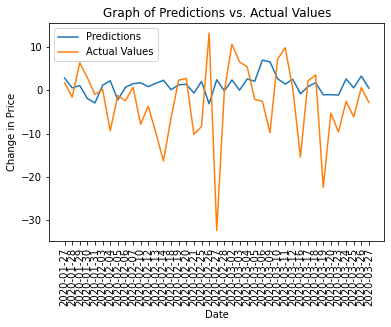

In [8]:
plt.plot(data.index[:len(lin_predictions)], lin_predictions)
plt.plot(data.index[:len(lin_y_test)], lin_y_test)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Change in Price')
plt.title('Graph of Predictions vs. Actual Values')
plt.legend(["Predictions","Actual Values"])
plt.show()

### Random Forest Regressor
We assumed that the Linear Regression model was underfitting because of a lack of data, we decided to try a Random Forest Regressor that included a bootstrap parameter.

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

rf_x_train, rf_x_test, rf_y_train, rf_y_test = train_test_split(X, Y, test_size=0.2)
rf = RandomForestRegressor(n_estimators = 10000, random_state=0, bootstrap=True)
rf.fit(rf_x_train, rf_y_train)
rf_predictions = rf.predict(rf_x_test)
rf_error = mean_squared_error(rf_y_test, rf_predictions) 
print(rf_error)

115.96073060919052


Again, the model underfitted.

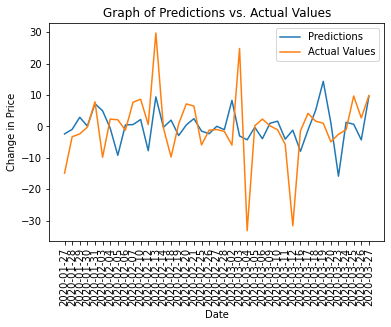

In [10]:
plt.plot(data.index[:len(rf_predictions)], rf_predictions)
plt.plot(data.index[:len(rf_y_test)], rf_y_test)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Change in Price')
plt.title('Graph of Predictions vs. Actual Values')
plt.legend(["Predictions","Actual Values"])
plt.show()

### Support Vector Regression
We decided to try out the support vector regression model to see if we could improve our regression predictions. One difference that we had to do was normalize the X data since one of the requirements of SVR is that the input is normalized.

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

scaler = MinMaxScaler(feature_range=(-1,1))
x_scaled = scaler.fit_transform(X)

svr_x_train, svr_x_test, svr_y_train, svr_y_test = train_test_split(x_scaled, Y, test_size=0.2)

In [12]:
svmRegressor = SVR(kernel='rbf')
svmRegressor.fit(svr_x_train, svr_y_train)

SVR()

In [13]:
svr_predictions = svmRegressor.predict(svr_x_test)
error = mean_squared_error(svr_y_test, svr_predictions) 
print(error)

114.33340668734292


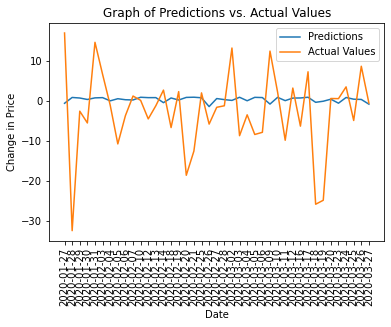

In [14]:
plt.plot(data.index[:len(svr_predictions)], svr_predictions)
plt.plot(data.index[:len(svr_y_test)], svr_y_test)
plt.title('Graph of Predictions vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Change in Price')
plt.xticks(rotation=90)
plt.legend(["Predictions","Actual Values"])
plt.show()

We believe that the results for SVR are inaccurate because the model is not complex enough to properly predict the erratic changes in change in price.

### KNeighborsRegressor

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

knr_x_train, knr_x_test, knr_y_train, knr_y_test = train_test_split(X, Y, test_size=0.2)

x_min_max_scaled_train = scaler.fit_transform(knr_x_train)
x_min_max_scaled_test = scaler.fit_transform(knr_x_test)

In [16]:
# Used to select best K for # of neighbors
mse_val = []
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_min_max_scaled_train, knr_y_train)
    pred=model.predict(x_min_max_scaled_test)
    error = mean_squared_error(knr_y_test,pred)
    mse_val.append(error)
    print('MSE value for k= ' , K , 'is:', error)

MSE value for k=  1 is: 174.62601475679833
MSE value for k=  2 is: 214.20828634361942
MSE value for k=  3 is: 176.3330276397011
MSE value for k=  4 is: 179.13247983051787
MSE value for k=  5 is: 195.22695692612362
MSE value for k=  6 is: 192.41908200762416
MSE value for k=  7 is: 184.93746719771383
MSE value for k=  8 is: 174.6518802848025
MSE value for k=  9 is: 176.85641394568842
MSE value for k=  10 is: 167.74219496046385
MSE value for k=  11 is: 166.11852454074665
MSE value for k=  12 is: 161.0605496979556
MSE value for k=  13 is: 155.9359976498723
MSE value for k=  14 is: 154.22830125622886
MSE value for k=  15 is: 155.34390286860713
MSE value for k=  16 is: 153.1678444615461
MSE value for k=  17 is: 152.13653063203122
MSE value for k=  18 is: 151.4232462462902
MSE value for k=  19 is: 153.7934377278747
MSE value for k=  20 is: 156.63883392535405


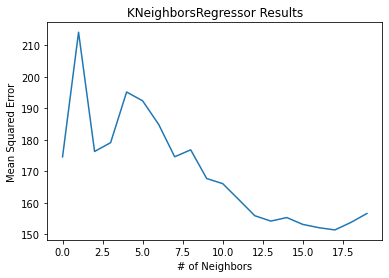

In [17]:
plt.title('KNeighborsRegressor Results')
plt.xlabel('# of Neighbors')
plt.ylabel('Mean Squared Error')
plt.plot(pd.DataFrame(mse_val))

In [18]:
# Select best k neighbor
model = KNeighborsRegressor(n_neighbors = 18)

model.fit(x_min_max_scaled_train, knr_y_train)
knr_pred=model.predict(x_min_max_scaled_test)
knr_error = mean_squared_error(knr_y_test, knr_pred)
print('MSE value', knr_error)

MSE value 151.4232462462902


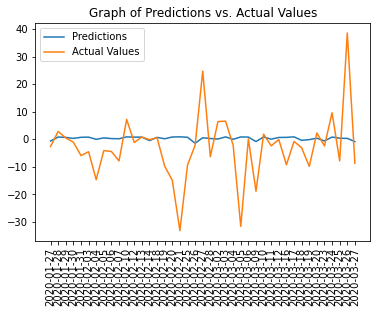

In [19]:
plt.plot(data.index[:len(knr_pred)], svr_predictions)
plt.plot(data.index[:len(knr_y_test)], knr_y_test)
plt.title('Graph of Predictions vs. Actual Values')
plt.xticks(rotation=90)
plt.legend(["Predictions","Actual Values"])
plt.show()

From the following results, we can conclude that the RandomForestRegressor produces the best results (upon analyzing the graph and not looking at the error results). We believe this is because Random Forest is a nonlinear model in comparison to a Linear Regression model.

## Classification
Due to the large error in the regression models, we decided to try predicting whether the stock price went up or down because we thought this was an easier problem.

### Setup

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

data = pd.read_csv('data/sentiment.csv', index_col=0)
data = data.drop(columns=['Text'])
data["Change"] = np.where(data["Change In Price"]>0,1,0)
data["Change In Price"] = data["Change In Price"].abs()
data["Retweets*Neg"] = data["Retweets"]*data["Negative"]
data["Retweets*Pos"] = data["Retweets"]*data["Positive"]
data.head()

,Change In Price,Favorites,Retweets,Negative,Neutral,Positive,Compound,Change,Retweets*Neg,Retweets*Pos
2020-01-27,3.205994,6544.600000,814.000000,0.030,0.853,0.117,0.7959,1,24.4200,95.238000
2020-01-28,0.318001,79576.500000,6452.666667,0.000,0.813,0.187,0.8718,0,0.0000,1206.648667
2020-01-29,1.059998,35996.769231,4025.000000,0.028,0.715,0.257,0.9775,1,112.7000,1034.425000
2020-01-30,1.678001,53946.166667,4608.000000,0.129,0.842,0.028,-0.5707,1,594.4320,129.024000
2020-01-31,2.113998,53814.944444,5062.500000,0.043,0.716,0.241,0.9726,1,217.6875,1220.062500


### Normalization
Based on advice we received in office hours, we decided to scale and center our data. We also experimented with removing the compound feature from the sentiment analysis and including two new features (the number of retweets multipled by the positive rating from the sentiment analysis and the number of retweets multipled by the negative rating from the sentiment analysis). We did this because the more polarizing a tweet is the more retweets it should get. These kinds of tweets should impact the stock price more.

In [21]:
X = data[["Favorites", "Retweets", "Negative", "Positive", "Retweets*Neg", "Retweets*Pos"]]
Y = data["Change"]
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
print(X)

[[-0.22753503 -0.14847375 -0.33916018 -0.55917103 -0.07615991 -0.48496965]
 [ 0.39485523  0.10558221 -0.68389528  0.05637419 -0.07776686  1.12491692]
 [ 0.02346136 -0.00379882 -0.36214252  0.67191941 -0.07035066  0.87544966]
 ...
 [-0.15774485 -0.16225864 -0.30468667 -0.53279052 -0.0766636  -0.5346129 ]
 [-0.26031564 -0.18056593 -0.39661603  1.4721282  -0.07759951 -0.57164386]
 [-0.22954115 -0.17562752 -0.28170433  0.28500527 -0.07728013 -0.55771949]]


### KNeighbors Classifer
First we tried Knearest neighbors with little success.

In [22]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.44776119402985076

### Decision Tree Classifier
After that we attempted a decision tree classifier, also with little success.

In [23]:
# Creates the Decision Tree Classifier
model=tree.DecisionTreeClassifier(max_depth=2)

#TODO: train the model
model.fit(x_train,y_train)
model.score(x_test, y_test)

0.4626865671641791

### Logistic Regression
Based on advice we received in office hours, we used the Logistic Regression model decision function to see which features were having the greatest impact on the model in an attempt to see which ones should be removed/weighted more heavily.

In [24]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print(clf.decision_function(X))
clf.score(x_test, y_test)

[ 6.22236428e-02 -3.87909814e-01 -1.14166898e-01 -6.81763304e-01
 -3.29628980e-01 -1.51388306e-01  1.84159374e-01 -1.14470488e-01
 -2.15689220e-01  2.89773815e-01 -1.06276439e-02 -1.73908607e-01
 -1.24979143e+00  6.11298700e-02  4.46018165e-01  2.98339876e-01
 -9.84739433e-02 -1.15008654e+00 -2.62906978e-01 -2.77668541e-02
  1.04230092e-01  1.95601872e-01  2.27272089e-02 -7.00398987e-01
  3.02580651e-01 -3.25765685e-02 -1.27700344e+01 -3.65122542e-01
 -5.13501075e-01 -4.46548228e-01 -5.46368415e-01 -9.71836053e-02
 -4.77380639e-02 -5.14750630e-02 -2.76784142e-02  1.27889461e-01
  1.35284650e-01  1.07036325e-01  1.09362290e-01 -1.05458190e-01
  2.03632888e-01 -4.65511276e-02 -5.14763414e-01  5.59600472e-01
 -1.58397156e-01  9.89276997e-02 -3.40617383e-02  1.92369051e-01
 -2.40717926e-01  8.91131889e-01 -4.96355693e-01  1.87301914e-01
  6.02628239e-02  4.81362012e-02 -5.53807484e-02  3.78040726e-01
  3.70815039e-01 -1.00512398e-01  2.85768587e-01 -3.15104474e-01
  2.52551877e-02  2.96865

0.5223880597014925

## Conclusion
Ultimately, we were unable to prove a correlation between Elons' tweets and Tesla stock price. However, we believe this is due to a view issues in the way we process the data. The primary issue is the lack of data. The secondary issue is that because we look at stock price by day and therefore tweets by day, if Elon tweets a negative tweet and a positive tweet in the same day the sentiment analysis for each tweet cancels out. We found this to be the case most days.